In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import missingno as msno # 결측치를 확인할 수 있는 라이브러리
import os
import sys

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

# 컬럼 표시 제한
# pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)

# 1. 상황인식

1.배경

안녕하세요 여러분! 구내식당 식수 인원 예측 AI 경진대회에 오신 것을 환영합니다.

지금까지는 단순한 시계열 추세와 담당자의 직관적 경험에 의존하여한국토지주택공사 구내식당 식수 인원을 예측하였으나,

빅데이터 분석으로 얻어지는 보다 정확도 높은 예측을 통해 "잔반 발생량을 획기적으로 줄이고자" 합니다.

 
2.목적

구내식당의 요일별 점심, 저녁식사를 먹는 인원을 예측

___________________________________________________________________________________________________________________


3.	평가

평가산식 : MAE(Mean Absolute Error)
Public 평가 : 전체 Test 데이터 중 무작위 30 % (15일)
Private 평가 : 전체 Test 데이터 중 나머지 70 % (35일)


4. 외부 데이터 및 사전학습 모델

공공 데이터와 같이 누구나 얻을 수 있고 법적 제약이 없는 외부 데이터 허용
사전학습 모델의 경우 사전학습에 사용된 데이터를 명시해야함
최종 평가시 외부데이터 및 출처 제출


5. 코드 평가

다음 조건을 만족하며 제출한 코드로 Private score가 복원된 상위 3팀에게 상금을 수여합니다.
조건 1. Private 순위 공개 후 코드 제출 기간 내 코드 코드공유 게시판 게시한 팀(설명 PPT dacon@dacon.io로 제출)
			제목 양식 : 팀이름, Private 순위와 Private 점수, 모델 이름

			내 용 : 전처리, 학습, 후처리, 추론 일련의 과정을 담은 코드를 게시

			예시) 데이콘팀, Private 1위, Private 점수 : 5.23, ResNet

# 2. 데이터 분석

In [2]:
train_df = pd.read_csv('restaurant/train.csv')
train_df.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0


In [3]:
test_df = pd.read_csv('restaurant/test.csv')
test_df.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [4]:
submission_df = pd.read_csv('restaurant/sample_submission.csv')
submission_df.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [5]:
train_df['일자'] = train_df['일자'].str.replace('-', '')
train_df.insert(0, 'date', train_df['일자'].str[2:8])
train_df.columns=['date','일자','요일','정원','휴가자','출장자','시간외근무','재택근무','조식','중식','석식','중식계','석식계']
train_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식,중식계,석식계
0,160201,20160201,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0


In [6]:
# train_df['재택근무'].unique()

In [7]:
# train_df['중식계'].unique()

In [8]:
# train_df['석식계'].unique()

In [9]:
train_df['재택근무'] = train_df['재택근무'].astype(int)
train_df['중식계'] = train_df['중식계'].astype(int)
train_df['석식계'] = train_df['석식계'].astype(int)
train_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식,중식계,석식계
0,160201,20160201,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1205 non-null   object
 1   일자      1205 non-null   object
 2   요일      1205 non-null   object
 3   정원      1205 non-null   int64 
 4   휴가자     1205 non-null   int64 
 5   출장자     1205 non-null   int64 
 6   시간외근무   1205 non-null   int64 
 7   재택근무    1205 non-null   int64 
 8   조식      1205 non-null   object
 9   중식      1205 non-null   object
 10  석식      1205 non-null   object
 11  중식계     1205 non-null   int64 
 12  석식계     1205 non-null   int64 
dtypes: int64(7), object(6)
memory usage: 122.5+ KB


In [11]:
test_df['일자'] = test_df['일자'].str.replace('-', '')
test_df.insert(0, 'date', test_df['일자'].str[2:8])
test_df.columns=['date','일자','요일','정원','휴가자','출장자','시간외근무','재택근무','조식','중식','석식']
test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식
0,210127,20210127,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [12]:
test_df['재택근무'] = train_df['재택근무'].astype(int)
test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식
0,210127,20210127,수,2983,88,182,5,0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    50 non-null     object
 1   일자      50 non-null     object
 2   요일      50 non-null     object
 3   정원      50 non-null     int64 
 4   휴가자     50 non-null     int64 
 5   출장자     50 non-null     int64 
 6   시간외근무   50 non-null     int64 
 7   재택근무    50 non-null     int64 
 8   조식      50 non-null     object
 9   중식      50 non-null     object
 10  석식      50 non-null     object
dtypes: int64(5), object(6)
memory usage: 4.4+ KB


In [14]:
# sample_submission = pd.read_csv('restaurant/sample_submission.csv')
# sample_submission

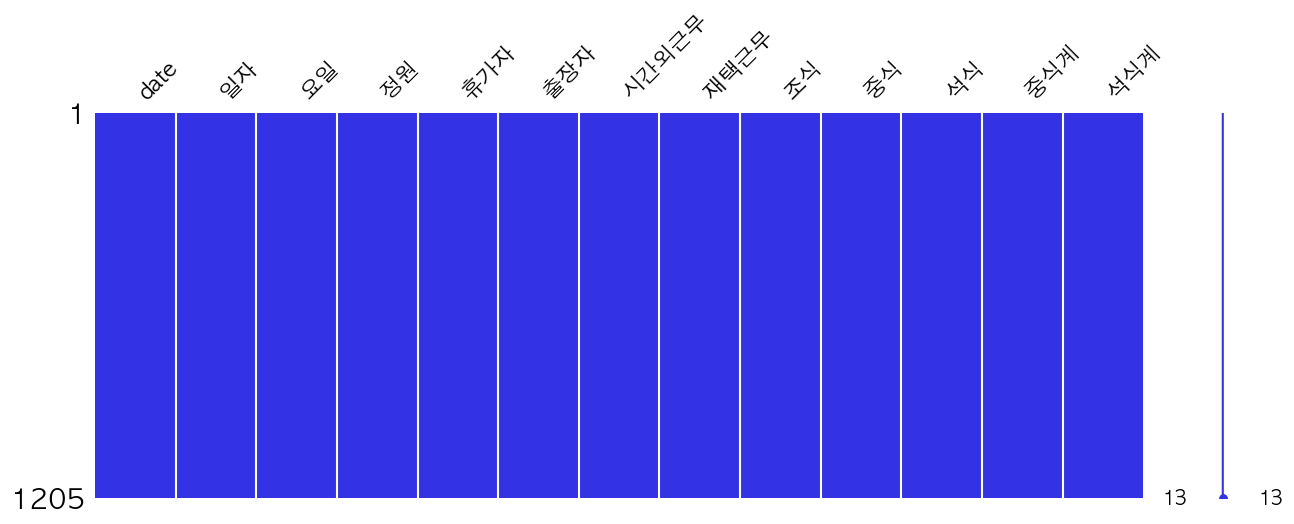

In [15]:
msno.matrix(df=train_df.iloc[:, :], color=(0.2, 0.2, 0.9), figsize=(15, 5));

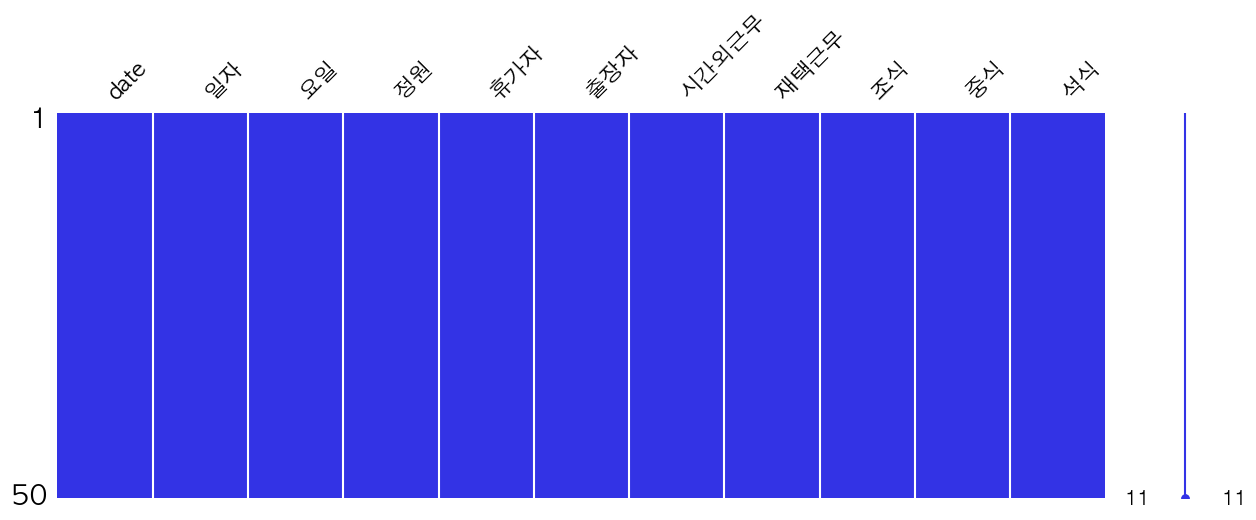

In [16]:
msno.matrix(df=test_df.iloc[:, :], color=(0.2, 0.2, 0.9), figsize=(15, 5));

In [17]:
train_df['조식'].head()

0    모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐...
1    모닝롤/단호박샌드  우유/두유/주스 계란후라이  팥죽/쌀밥 (쌀:국내산) 호박젓국찌...
2    모닝롤/베이글  우유/두유/주스 계란후라이  표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...
3    모닝롤/토마토샌드  우유/두유/주스 계란후라이  닭죽/쌀밥 (쌀,닭:국내산) 근대국...
4    모닝롤/와플  우유/두유/주스 계란후라이  쇠고기죽/쌀밥 (쌀:국내산) 재첩국  방...
Name: 조식, dtype: object

In [18]:
# '모닝롤/찐빵', '우유/두유/주스'....여기서 하나?

In [19]:
import re

def split_text(stringData):
    pattern1 = r'\([^)]*\)'
    
    text = re.sub(pattern=pattern1, repl='', string=stringData)
    
    text = text.replace('/',' ')
    text = text.replace('  ',' ')
    text = text.replace('*',' ')
    if text[-1] == ' ':
        text = text[:-1]
    return text

In [20]:
train_df['조식'] = train_df['조식'].apply(split_text)
train_df['중식'] = train_df['중식'].apply(split_text)
train_df['석식'] = train_df['석식'].apply(split_text)

test_df['조식'] = train_df['조식'].apply(split_text)
test_df['중식'] = train_df['중식'].apply(split_text)
test_df['석식'] = train_df['석식'].apply(split_text)

print(train_df['조식'][0])
print(train_df['중식'][0])
print(train_df['석식'][0])
print()
print(test_df['조식'][0])
print(test_df['중식'][0])
print(test_df['석식'][0])

모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치
쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치
쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치

모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치
쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치
쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치


In [21]:
train_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식,중식계,석식계
0,160201,20160201,월,2601,50,150,238,0,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,1039,331


In [22]:
test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식
0,210127,20210127,수,2983,88,182,5,0,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치


In [23]:
morning_menu_list = []
lunch_menu_list = []
dinner_menu_list = []

for i in train_df['조식']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        morning_menu_list.append(j)
        
for i in train_df['중식']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        lunch_menu_list.append(j)
        
for i in train_df['석식']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        dinner_menu_list.append(j)
        
morning_menu_list[0]

'모닝롤'

In [24]:
type(morning_menu_list)

list

In [25]:
list(set(morning_menu_list))

['',
 '식빵피자',
 '선지해장국',
 '매운감자국',
 '딸기파이',
 '배추시래기국',
 '진미채볶음',
 '바지락쑥국',
 '재래김',
 '녹차호떡',
 '시래기조림',
 '홍루이젠',
 '땅콩조림',
 '모닝샌드위치',
 '인절미토스트',
 '비엔나곤약조림',
 '고구마파이',
 '흑미두부죽',
 'BLT샌드위치',
 '애플잼쿠키',
 '대만식연유샌드위치',
 '비엔나채소볶음',
 '삶은계란',
 '순두부탕',
 '버섯볶음',
 '양배추샐러드',
 '순두부계란국',
 '보리누룽지탕',
 '분홍소세지구이',
 '소고기미역국',
 '땅콩샌드',
 '베이컨샌드위치',
 '어묵꽈리고추볶음',
 '김실파무침',
 '노각무침',
 '시금치샐러드',
 '멸치아몬드볶음',
 '브로컬리된장무침',
 '모듬묵샐러드',
 '수제비국',
 '햄치즈샌드위치',
 '에그단호박샌드',
 '시금치두부무침',
 '소고기스프',
 '달래양념장',
 '비엘티샌드위치',
 '고구마죽',
 '냉이된장국',
 '두부구이',
 '두반장가지볶음',
 '블루베리사과샌드',
 '딤섬',
 '땅콩죽',
 '바지락죽',
 '치즈볼',
 '시금치죽',
 '새우살미역국',
 '꽈리고추찜',
 '브로컬리들깨소스',
 '마늘바게트',
 '쑥갓겉절이',
 '두부동그랑땡',
 '토란국',
 '멸치고추장무침',
 '베이컨에그슬럿',
 '우거지국',
 '쇠고기마늘죽',
 '홍합살무국',
 '매운사태조림',
 '바지락콩나물국',
 '깻잎순볶음',
 '베이글',
 '호박볶음',
 '양념',
 '피홍합탕',
 '롤케이크',
 '감자된장찌개',
 '모닝샌드',
 '콩가루배추국',
 '호떡',
 '우거지해장국',
 '호밧젓국찌개',
 '얼갈이겉절이',
 '섭산적채소조림',
 '열무김치',
 '얼큰소고기국',
 '크로아상샌드위치',
 '브로콜리스프',
 '김치어묵국',
 '고기완자전',
 '프레즐',
 '버섯비엔나조림',
 '보코치니샐러드',
 '호빵',
 '도토리묵무침',
 '브로콜리감자볶음',
 '피바지락배추국',
 

In [26]:
len(morning_menu_list)

12302

In [27]:
len(list(set(morning_menu_list)))

787

In [28]:
lunch_menu_list[1]

'잡곡밥'

In [29]:
dinner_menu_list[2]

'육개장'

In [30]:
train_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식,중식계,석식계
0,160201,20160201,월,2601,50,150,238,0,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,1039,331


In [31]:
train_df.insert(8, '근무중인원', train_df['정원']-train_df['휴가자']-train_df['출장자']+train_df['시간외근무']-train_df['재택근무'])
train_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,근무중인원,조식,중식,석식,중식계,석식계
0,160201,20160201,월,2601,50,150,238,0,2639,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,1039,331


In [32]:
test_df.insert(8, '근무중인원', test_df['정원']-test_df['휴가자']-test_df['출장자']+test_df['시간외근무']-test_df['재택근무'])
test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,근무중인원,조식,중식,석식
0,210127,20210127,수,2983,88,182,5,0,2718,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치


In [33]:
train_df.corr()

,정원,휴가자,출장자,시간외근무,재택근무,근무중인원,중식계,석식계
정원,1.000000,0.244666,-0.061688,0.146544,0.452293,0.362927,-0.115529,-0.173852
휴가자,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.448198,-0.391975,-0.316894
출장자,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.150785,-0.512680,-0.188164
시간외근무,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.873177,0.535611,0.571168
재택근무,0.452293,0.065397,-0.352643,0.156792,1.000000,0.034990,0.076509,-0.057534
근무중인원,0.362927,-0.448198,-0.150785,0.873177,0.034990,1.000000,0.529821,0.496586
중식계,-0.115529,-0.391975,-0.512680,0.535611,0.076509,0.529821,1.000000,0.508287
석식계,-0.173852,-0.316894,-0.188164,0.571168,-0.057534,0.496586,0.508287,1.000000


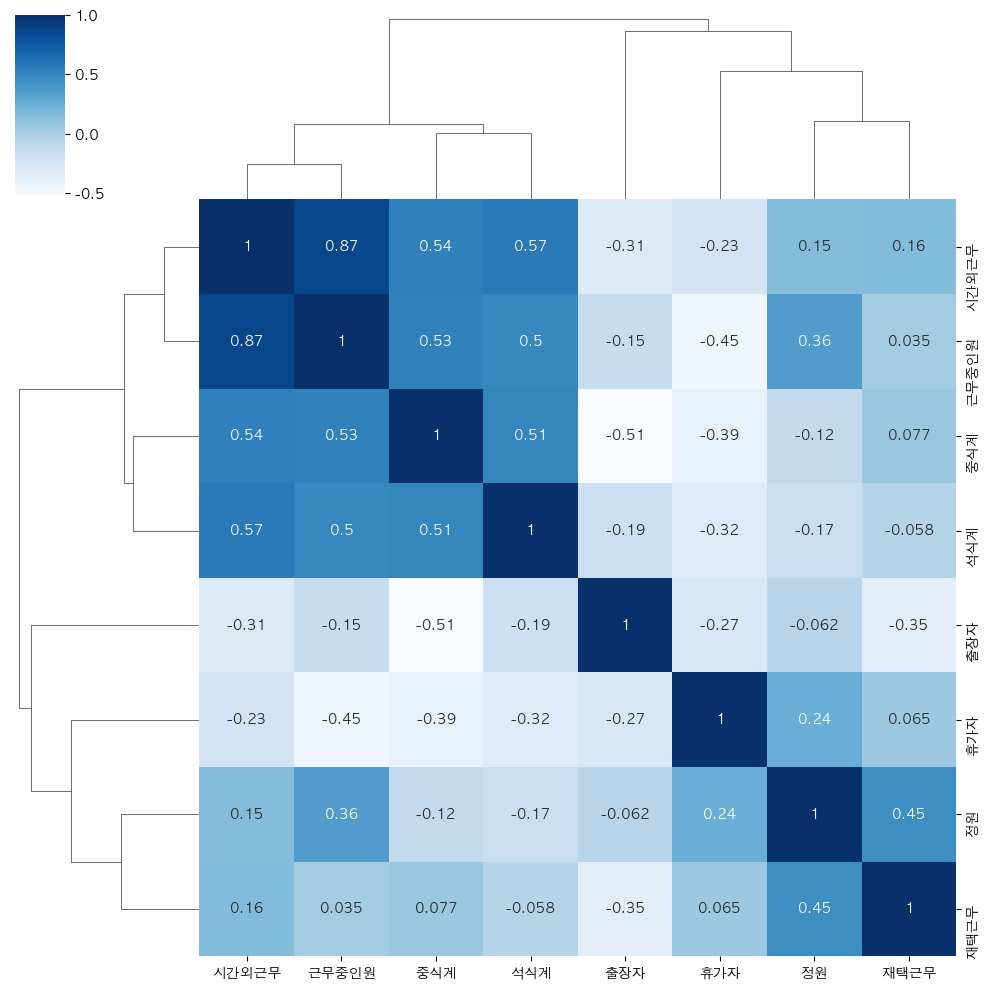

In [34]:
sns.clustermap(train_df.corr(), annot=True, cmap='Blues')
plt.show()

### 상관계수

근무중인원 - 시간외근무 (0.87)

근무중인원 - 중식계 (0.53)

근무중인원 - 석식계 (0.5)

중식계 - 석식계 (0.51)

In [35]:
# cf.) 데이콘 베이스라인 코드 (랜덤포레스트)

In [36]:
train_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,근무중인원,조식,중식,석식,중식계,석식계
0,160201,20160201,월,2601,50,150,238,0,2639,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,1039,331


In [37]:
test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,근무중인원,조식,중식,석식
0,210127,20210127,수,2983,88,182,5,0,2718,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치


In [38]:
train = train_df.copy()
test = test_df.copy()
submission = submission_df.copy()

In [39]:
train['요일'] = train['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
test['요일'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

In [40]:
x_train = train[['요일', '정원', '휴가자', '출장자', '시간외근무', '재택근무', '근무중인원']]
y1_train = train['중식계']
y2_train = train['석식계']

x_test = test[['요일', '정원', '휴가자', '출장자', '시간외근무', '재택근무', '근무중인원']]

In [41]:
x_train

,요일,정원,휴가자,출장자,시간외근무,재택근무,근무중인원
0,0,2601,50,150,238,0,2639
1,1,2601,50,173,319,0,2697
2,2,2601,56,180,111,0,2476
3,3,2601,104,220,355,0,2632
4,4,2601,278,181,34,0,2176
...,...,...,...,...,...,...,...
1200,2,2983,75,198,4,391,2323
1201,3,2983,92,231,462,351,2771
1202,4,2983,255,248,1,303,2178
1203,0,2983,107,153,616,327,3012


In [42]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   요일      1205 non-null   int64
 1   정원      1205 non-null   int64
 2   휴가자     1205 non-null   int64
 3   출장자     1205 non-null   int64
 4   시간외근무   1205 non-null   int64
 5   재택근무    1205 non-null   int64
 6   근무중인원   1205 non-null   int64
dtypes: int64(7)
memory usage: 66.0 KB


In [43]:
# 점심과 저녁을 식수 인원을 예측할 2개 모델 생성

from sklearn.ensemble import RandomForestRegressor

model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

In [44]:
# 학습
model1.fit(x_train, y1_train)
model2.fit(x_train, y2_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [45]:
# 예측
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)

In [46]:
submission['중식계'] = pred1
submission['석식계'] = pred2

In [47]:
submission.to_csv('restaurant/submission.csv', index=False)

In [48]:
submission.head()

,일자,중식계,석식계
0,2021-01-27,1085.41,289.38
1,2021-01-28,934.22,516.52
2,2021-01-29,578.58,301.75
3,2021-02-01,1215.18,580.06
4,2021-02-02,1026.12,504.75
